In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import operator
from functools import reduce
from pandas import concat
import math
from math import pi
# from sklearn.datasets import load_boston
import copy
from sklearn.ensemble import RandomForestRegressor

In [3]:
# 计算两个经纬度之间的距离
def getDistance(latA, lonA, latB, lonB):
    ra = 6378136.49  # radius of equator: meter
    rb = 6356755  # radius of polar: meter

    flatten = (ra - rb) / ra  # Partial rate of the earth
    # change angle to radians
    radLatA = math.radians(latA)
    radLonA = math.radians(lonA)
    radLatB = math.radians(latB)
    radLonB = math.radians(lonB)
 
    pA = math.atan(rb / ra * math.tan(radLatA))
    pB = math.atan(rb / ra * math.tan(radLatB))
    if radLonA == radLonB:
        x = math.acos(math.sin(pA) * math.sin(pB) + math.cos(pA) * math.cos(pB) * math.cos(0.001))
    else:
        x = math.acos(math.sin(pA) * math.sin(pB) + math.cos(pA) * math.cos(pB) * math.cos(radLonA - radLonB))
    c1 = (math.sin(x) - x) * (math.sin(pA) + math.sin(pB))**2 / math.cos(x / 2)**2
    c2 = (math.sin(x) + x) * (math.sin(pA) - math.sin(pB))**2 / math.sin(x / 2)**2
    dr = flatten / 8 * (c1 - c2)
    distance = ra * (x + dr)/1000
    
    dLon = radLonB - radLonA
    yy = math.sin(dLon) * math.cos(radLatB)
    xx = math.cos(radLatA) * math.sin(radLatB) - math.sin(radLatA) * math.cos(radLatB) * math.cos(dLon)
    brng = math.degrees(math.atan2(yy, xx))
    brng = (brng + 180) % 360
#     if brng>180:
#         brng=brng-360
#     brng=brng*math.pi/180
    return distance,brng

In [4]:
def remove_duplicates(input_list):
    new_list = []
    for element in input_list:
        if element not in new_list:
            new_list.append(element)
    return new_list

In [5]:
data_track = pd.read_csv("bouydata_4.csv")
numbers_pred = 12 #点数 # 数据时间分辨率 6小时  train_x \\ 用12 * 6 小时数据预报
forecast_hour = 24 #时间 # 预测时间序列   预报4个点（时间分辨率为6 hours）
feature_size = 17
point = 12
data_track  

,id,time,latitude,longitude,sst,VE,VN,SPD,VAR.LAT,VAR.LON,VAR.TEMP
0,107601,2014-12-22 06:00:00,22.547,124.965,24.658,-24.346,45.222,51.359,0.000009,0.000020,0.001724
1,107601,2014-12-22 12:00:00,22.657,124.938,24.485,-3.633,66.491,66.590,0.000004,0.000008,0.001584
2,107601,2014-12-22 18:00:00,22.807,124.949,24.320,-9.418,62.888,63.589,0.000006,0.000012,0.001869
3,107601,2014-12-23 00:00:00,22.902,124.898,24.148,-36.169,53.911,64.920,0.000004,0.000008,0.001665
4,107601,2014-12-23 06:00:00,23.017,124.797,24.101,-37.589,58.931,69.898,0.000009,0.000019,0.001918
...,...,...,...,...,...,...,...,...,...,...,...
69468,300534064920860,2023-10-13 12:00:00,21.221,111.331,27.962,-2.695,3.717,4.592,0.000002,0.000004,0.001684
69469,300534064920860,2023-10-13 18:00:00,21.219,111.327,27.754,-5.732,0.897,5.801,0.000002,0.000004,0.001684
69470,300534064920860,2023-10-14 00:00:00,21.225,111.308,27.740,-5.591,0.628,5.626,0.000002,0.000004,0.001684
69471,300534064920860,2023-10-14 06:00:00,21.221,111.304,27.896,-1.006,2.758,2.936,0.000002,0.000004,0.001684


In [6]:
clean_id = remove_duplicates(data_track['id'])
first_index = []
last_index = []
for i in range(len(clean_id)):
    index = data_track.index[data_track['id'] == clean_id[i]].tolist()
    first_index.append(index[0])
    last_index.append(index[-1])
print(len(first_index))

360


In [7]:
data_track = data_track.drop(columns=["id","time"])
data_track

,latitude,longitude,sst,VE,VN,SPD,VAR.LAT,VAR.LON,VAR.TEMP
0,22.547,124.965,24.658,-24.346,45.222,51.359,0.000009,0.000020,0.001724
1,22.657,124.938,24.485,-3.633,66.491,66.590,0.000004,0.000008,0.001584
2,22.807,124.949,24.320,-9.418,62.888,63.589,0.000006,0.000012,0.001869
3,22.902,124.898,24.148,-36.169,53.911,64.920,0.000004,0.000008,0.001665
4,23.017,124.797,24.101,-37.589,58.931,69.898,0.000009,0.000019,0.001918
...,...,...,...,...,...,...,...,...,...
69468,21.221,111.331,27.962,-2.695,3.717,4.592,0.000002,0.000004,0.001684
69469,21.219,111.327,27.754,-5.732,0.897,5.801,0.000002,0.000004,0.001684
69470,21.225,111.308,27.740,-5.591,0.628,5.626,0.000002,0.000004,0.001684
69471,21.221,111.304,27.896,-1.006,2.758,2.936,0.000002,0.000004,0.001684


In [8]:
def shift(data,forcast_hour):
    # 16为数据总时长(72+16)/6=16
    # 3为(4-1=3)   4*6=24   24为预报时长
    cols=[]
    lat_data=data['latitude']
    lon_data=data['longitude']
    for i in range(16,3,-1):
        cols.append(data.shift(i))
    for i in range(3,-1,-1):
        cols.append(lat_data.shift(i))
    for i in range(3,-1,-1):
        cols.append(lon_data.shift(i))        
    agg = pd.concat(cols, axis=1)
    essemble=agg.dropna(axis=0,how='any')
    return essemble

In [9]:
def dis_direct(data,forecast_hour):
    dif_essemble=[]
    point=numbers_pred
    mm=9   # 表示源数据集中有九个特征值
    for i in range(len(data)):
        x_essemble=[]
        for j in range(0,numbers_pred,1):   # 提取用于预测的数据、特征展开
            # print(len(data[i]))
            lon0  = data[i][point*mm+1]
            lat0  = data[i][point*mm]
            
            lon1 = data[i][j*mm+1]
            lat1 = data[i][j*mm]

    ### -----
            lon2 = data[i][(j+1)*mm+1]
            lat2 = data[i][(j+1)*mm]
            
            sst = data[i][(j+1)*mm+2]
            ve = data[i][(j+1)*mm+3]
            vn = data[i][(j+1)*mm+4]
            spd = data[i][(j+1)*mm+5]

            varlat = data[i][(j+1)*mm+6]
            varlon = data[i][(j+1)*mm+7]
            vartemp = data[i][(j+1)*mm+8]
            distance,brng=getDistance(lat1, lon1, lat0, lon0)  # 计算0 1 2 3 与 5的距离和方位角 （如果起始只有一个点进行预报，无法计算这个变量）
            
            dif_lat=data[i][point*mm]-data[i][j*mm]
            dif_lon=data[i][point*mm+1]-data[i][j*mm+1]
            dif_sst=data[i][point*mm+2]-data[i][j*mm+2]
            dif_ve=data[i][point*mm+3]-data[i][j*mm+3]
            dif_vn=data[i][point*mm+4]-data[i][j*mm+4]
            dif_spd=data[i][point*mm+5]-data[i][j*mm+5]

            
            # 添加17个特征值
            x_essemble.append(lat2)
            x_essemble.append(lon2)
            x_essemble.append(sst)
            x_essemble.append(ve)
            x_essemble.append(vn)
            x_essemble.append(spd)
            x_essemble.append(varlat)
            x_essemble.append(varlon)
            x_essemble.append(vartemp)
            x_essemble.append(brng)
            x_essemble.append(dif_lat)
            x_essemble.append(dif_lon)
            x_essemble.append(dif_sst)
            x_essemble.append(dif_ve)
            x_essemble.append(dif_vn)
            x_essemble.append(dif_spd)
            x_essemble.append(distance)

            # print(lat0)

        fore_point=int(forecast_hour/6)   
        for j in range(fore_point):
          
            # dif_lat = data[i][(point+1)*mm+j] 
            # dif_lon=data[i][(point+1)*mm+j+fore_point] 

            dif_lat = data[i][(point+1)*mm+j] -data[i][point*mm]
            dif_lon=data[i][(point+1)*mm+j+fore_point] -data[i][point*mm+1]

            x_essemble.append(dif_lat)
            x_essemble.append(dif_lon)
        x_essemble.append(lat0)
        x_essemble.append(lon0)
        dif_essemble.append(x_essemble)  
    return dif_essemble

In [10]:
essemble_test = []
forecast_hours = 24
for i in range(len(first_index)):
# for i in range(3):  
    print(i)
    data = data_track[first_index[i]:last_index[i]+1]
    dataframe_trace = pd.DataFrame(data)
    essemble = shift(dataframe_trace, forecast_hours)
    essemble_values = essemble.values
    essemble_list = essemble_values.tolist()
    dif_data = dis_direct(essemble_list,forecast_hours)
    essemble_test.append(dif_data)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
print(len(essemble_test))
print(len(essemble_test[0]))

360
21


In [12]:
essemble_ds=reduce(operator.add, essemble_test)
print(len(essemble_ds[0]))

214


In [13]:
aaa = pd.DataFrame(essemble_ds)
aaa

,0,1,2,3,4,5,6,7,8,9,...,204,205,206,207,208,209,210,211,212,213
0,22.657,124.938,24.485,-3.633,66.491,66.590,0.000004,0.000008,0.001584,127.292957,...,-0.083,-0.079,-0.234,-0.092,-0.360,-0.148,-0.456,-0.135,23.283,123.908
1,22.807,124.949,24.320,-9.418,62.888,63.589,0.000006,0.000012,0.001869,118.211821,...,-0.151,-0.013,-0.277,-0.069,-0.373,-0.056,-0.491,0.042,23.200,123.829
2,22.902,124.898,24.148,-36.169,53.911,64.920,0.000004,0.000008,0.001665,103.277189,...,-0.126,-0.056,-0.222,-0.043,-0.340,0.055,-0.490,0.133,23.049,123.816
3,23.017,124.797,24.101,-37.589,58.931,69.898,0.000009,0.000019,0.001918,91.369211,...,-0.096,0.013,-0.214,0.111,-0.364,0.189,-0.437,0.237,22.923,123.760
4,23.132,124.740,23.993,-24.205,54.947,60.042,0.000006,0.000012,0.001427,78.809674,...,-0.118,0.098,-0.268,0.176,-0.341,0.224,-0.397,0.294,22.827,123.773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63708,21.585,112.983,27.978,-93.221,-42.390,102.406,0.000002,0.000004,0.001684,74.625584,...,0.005,-0.040,0.025,-0.089,0.021,-0.103,0.038,-0.110,21.183,111.441
63709,21.474,112.799,27.886,-97.435,-59.180,113.999,0.000002,0.000004,0.001684,75.206221,...,0.020,-0.049,0.016,-0.063,0.033,-0.070,0.031,-0.074,21.188,111.401
63710,21.354,112.577,27.840,-118.711,-42.979,126.252,0.000002,0.000004,0.001684,79.099398,...,-0.004,-0.014,0.013,-0.021,0.011,-0.025,0.017,-0.044,21.208,111.352
63711,21.305,112.305,27.671,-115.770,-28.536,119.235,0.000002,0.000004,0.001684,82.822546,...,0.017,-0.007,0.015,-0.011,0.021,-0.030,0.017,-0.034,21.204,111.338


In [14]:
print(len(essemble_ds))

63713


In [15]:
essemble_all_24 = np.array(essemble_ds)
print(essemble_all_24.shape)

(63713, 214)


In [16]:
#### 使用随机森林回归模型对数据进行拟合
def random_fit(essemble_all,forecast_hour):
#     essemble_all=np.array(essemble_all)
    result=0
    result_oob=0
    result_ds=[]
    for i in range(0,point):
        print(i)
        X = essemble_all[:,feature_size*i:feature_size*(i+1)]
        print(f"X.shape:{X.shape}")
        Y = essemble_all[:,(point*feature_size):(point*feature_size+int(forecast_hour/6))]
        print(f"Y.shape:{Y.shape}")
        rf = RandomForestRegressor(random_state=200,oob_score=True)
        rf.fit(X, Y)
        result+=rf.feature_importances_ 
        result_ds.append(rf.feature_importances_)
        result_oob+=rf.oob_score_ 
    importance_feature=result/point
    return importance_feature,result_ds

In [17]:
importance_feature_ds,result_ds=random_fit(essemble_all_24,24)

0
X.shape:(63713, 17)
Y.shape:(63713, 4)
1
X.shape:(63713, 17)
Y.shape:(63713, 4)
2
X.shape:(63713, 17)
Y.shape:(63713, 4)
3
X.shape:(63713, 17)
Y.shape:(63713, 4)
4
X.shape:(63713, 17)
Y.shape:(63713, 4)
5
X.shape:(63713, 17)
Y.shape:(63713, 4)
6
X.shape:(63713, 17)
Y.shape:(63713, 4)
7
X.shape:(63713, 17)
Y.shape:(63713, 4)
8
X.shape:(63713, 17)
Y.shape:(63713, 4)
9
X.shape:(63713, 17)
Y.shape:(63713, 4)
10
X.shape:(63713, 17)
Y.shape:(63713, 4)
11
X.shape:(63713, 17)
Y.shape:(63713, 4)


In [17]:
print(importance_feature_ds)
print(len(importance_feature_ds))

[0.01674567 0.02662099 0.01384748 0.053001   0.07261549 0.0281159
 0.00595079 0.00694312 0.00760109 0.16226162 0.18650538 0.0548286
 0.01267095 0.10649922 0.10832262 0.05649642 0.08097366]
17


In [18]:
print(len(result_ds))
print(len(result_ds[0]))

12
17


In [19]:
importance_feature_ds

array([0.01674567, 0.02662099, 0.01384748, 0.053001  , 0.07261549,
       0.0281159 , 0.00595079, 0.00694312, 0.00760109, 0.16226162,
       0.18650538, 0.0548286 , 0.01267095, 0.10649922, 0.10832262,
       0.05649642, 0.08097366])

In [20]:
import time
def select_combine(essemble_all,features_imp,select_num,forecast_hour):
#     i=int(forecast_hour/6)
    essemble_all=np.array(essemble_all)
    X1 = essemble_all[:,0:feature_size*point]
    X_train=X1.reshape(-1,point,feature_size)
    y_train = essemble_all[:,feature_size*point:feature_size*point+8]   # 这里的8表示有预测的lat和lon一共有8个
    oob_result = []
    fea_result = []
    features_imp = list(features_imp)
    iter_count = feature_size - select_num  #迭代次数
    if iter_count < 0:
        print("select_nume must less or equal X_train columns")
    else:
        features_test  = copy.deepcopy(features_imp)   #生成一个排序特征，进行筛选
        features_test.sort()
        features_test.reverse() 
        while iter_count >= 0:
            iter_count -= 1
            train_index = [features_imp.index(j) for j in features_test[:select_num]]
            train_data = X_train[:,:,train_index]
            acc=0
            print(train_data.shape)
            for m in range(point):
                print(f"{m} {time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))}")
                train_x=train_data[:,m,:]
                rf = RandomForestRegressor(random_state=200,oob_score=True)
                rf.fit(train_x,y_train)
                acc += rf.oob_score_
                # print(train_x.shape)
                # print(acc)
            acc=acc/point
            print('--------------------------------')
            print(acc)
            print('--------------------------------')
            oob_result.append(acc)
            fea_result.append(train_index)
            if select_num < feature_size:
                select_num += 1
            else:
                break
    return max(oob_result),oob_result,fea_result[oob_result.index(max(oob_result))]

In [21]:
score_max_24,oob_score_24,fea_result_24=select_combine(essemble_all=essemble_all_24,features_imp=importance_feature_ds,select_num=1,forecast_hour=24)

(63713, 12, 1)
0 2024-07-23 23:20:33
1 2024-07-23 23:20:42
2 2024-07-23 23:20:50
3 2024-07-23 23:21:00
4 2024-07-23 23:21:08
5 2024-07-23 23:21:16
6 2024-07-23 23:21:28
7 2024-07-23 23:21:35
8 2024-07-23 23:21:41
9 2024-07-23 23:21:47
10 2024-07-23 23:21:53
11 2024-07-23 23:21:58
--------------------------------
0.24690258946025764
--------------------------------
(63713, 12, 2)
0 2024-07-23 23:22:03
1 2024-07-23 23:22:26
2 2024-07-23 23:22:47
3 2024-07-23 23:23:07
4 2024-07-23 23:23:28
5 2024-07-23 23:23:48
6 2024-07-23 23:24:08
7 2024-07-23 23:24:27
8 2024-07-23 23:24:46
9 2024-07-23 23:25:05
10 2024-07-23 23:25:24
11 2024-07-23 23:25:42
--------------------------------
0.45003786183136335
--------------------------------
(63713, 12, 3)
0 2024-07-23 23:26:00
1 2024-07-23 23:26:27
2 2024-07-23 23:26:53
3 2024-07-23 23:27:20
4 2024-07-23 23:27:47
5 2024-07-23 23:28:19
6 2024-07-23 23:28:52
7 2024-07-23 23:29:23
8 2024-07-23 23:29:53
9 2024-07-23 23:30:20
10 2024-07-23 23:30:47
11 2024-

In [28]:
print(score_max_24,oob_score_24,fea_result_24)

0.8006886080259493 [0.24690258946025764, 0.45003786183136335, 0.6107205890026034, 0.7278015049981535, 0.7356972429868645, 0.7521332735148362, 0.7698900718330223, 0.7698784730575449, 0.7796363792445167, 0.7797623531308924, 0.7908141971232402, 0.7974120474666039, 0.8006739517849989, 0.8006886080259493, 0.8004410681945601, 0.8003975005936069, 0.8003391083160362] [10, 9, 14, 13, 16, 4, 15, 11, 3, 5, 1, 0, 2, 12]


In [23]:
oob_score_24

[0.24690258946025764,
 0.45003786183136335,
 0.6107205890026034,
 0.7278015049981535,
 0.7356972429868645,
 0.7521332735148362,
 0.7698900718330223,
 0.7698784730575449,
 0.7796363792445167,
 0.7797623531308924,
 0.7908141971232402,
 0.7974120474666039,
 0.8006739517849989,
 0.8006886080259493,
 0.8004410681945601,
 0.8003975005936069,
 0.8003391083160362]

In [24]:
score_max_24

0.8006886080259493

In [25]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'SimHei'  # 或其他支持中文的字体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

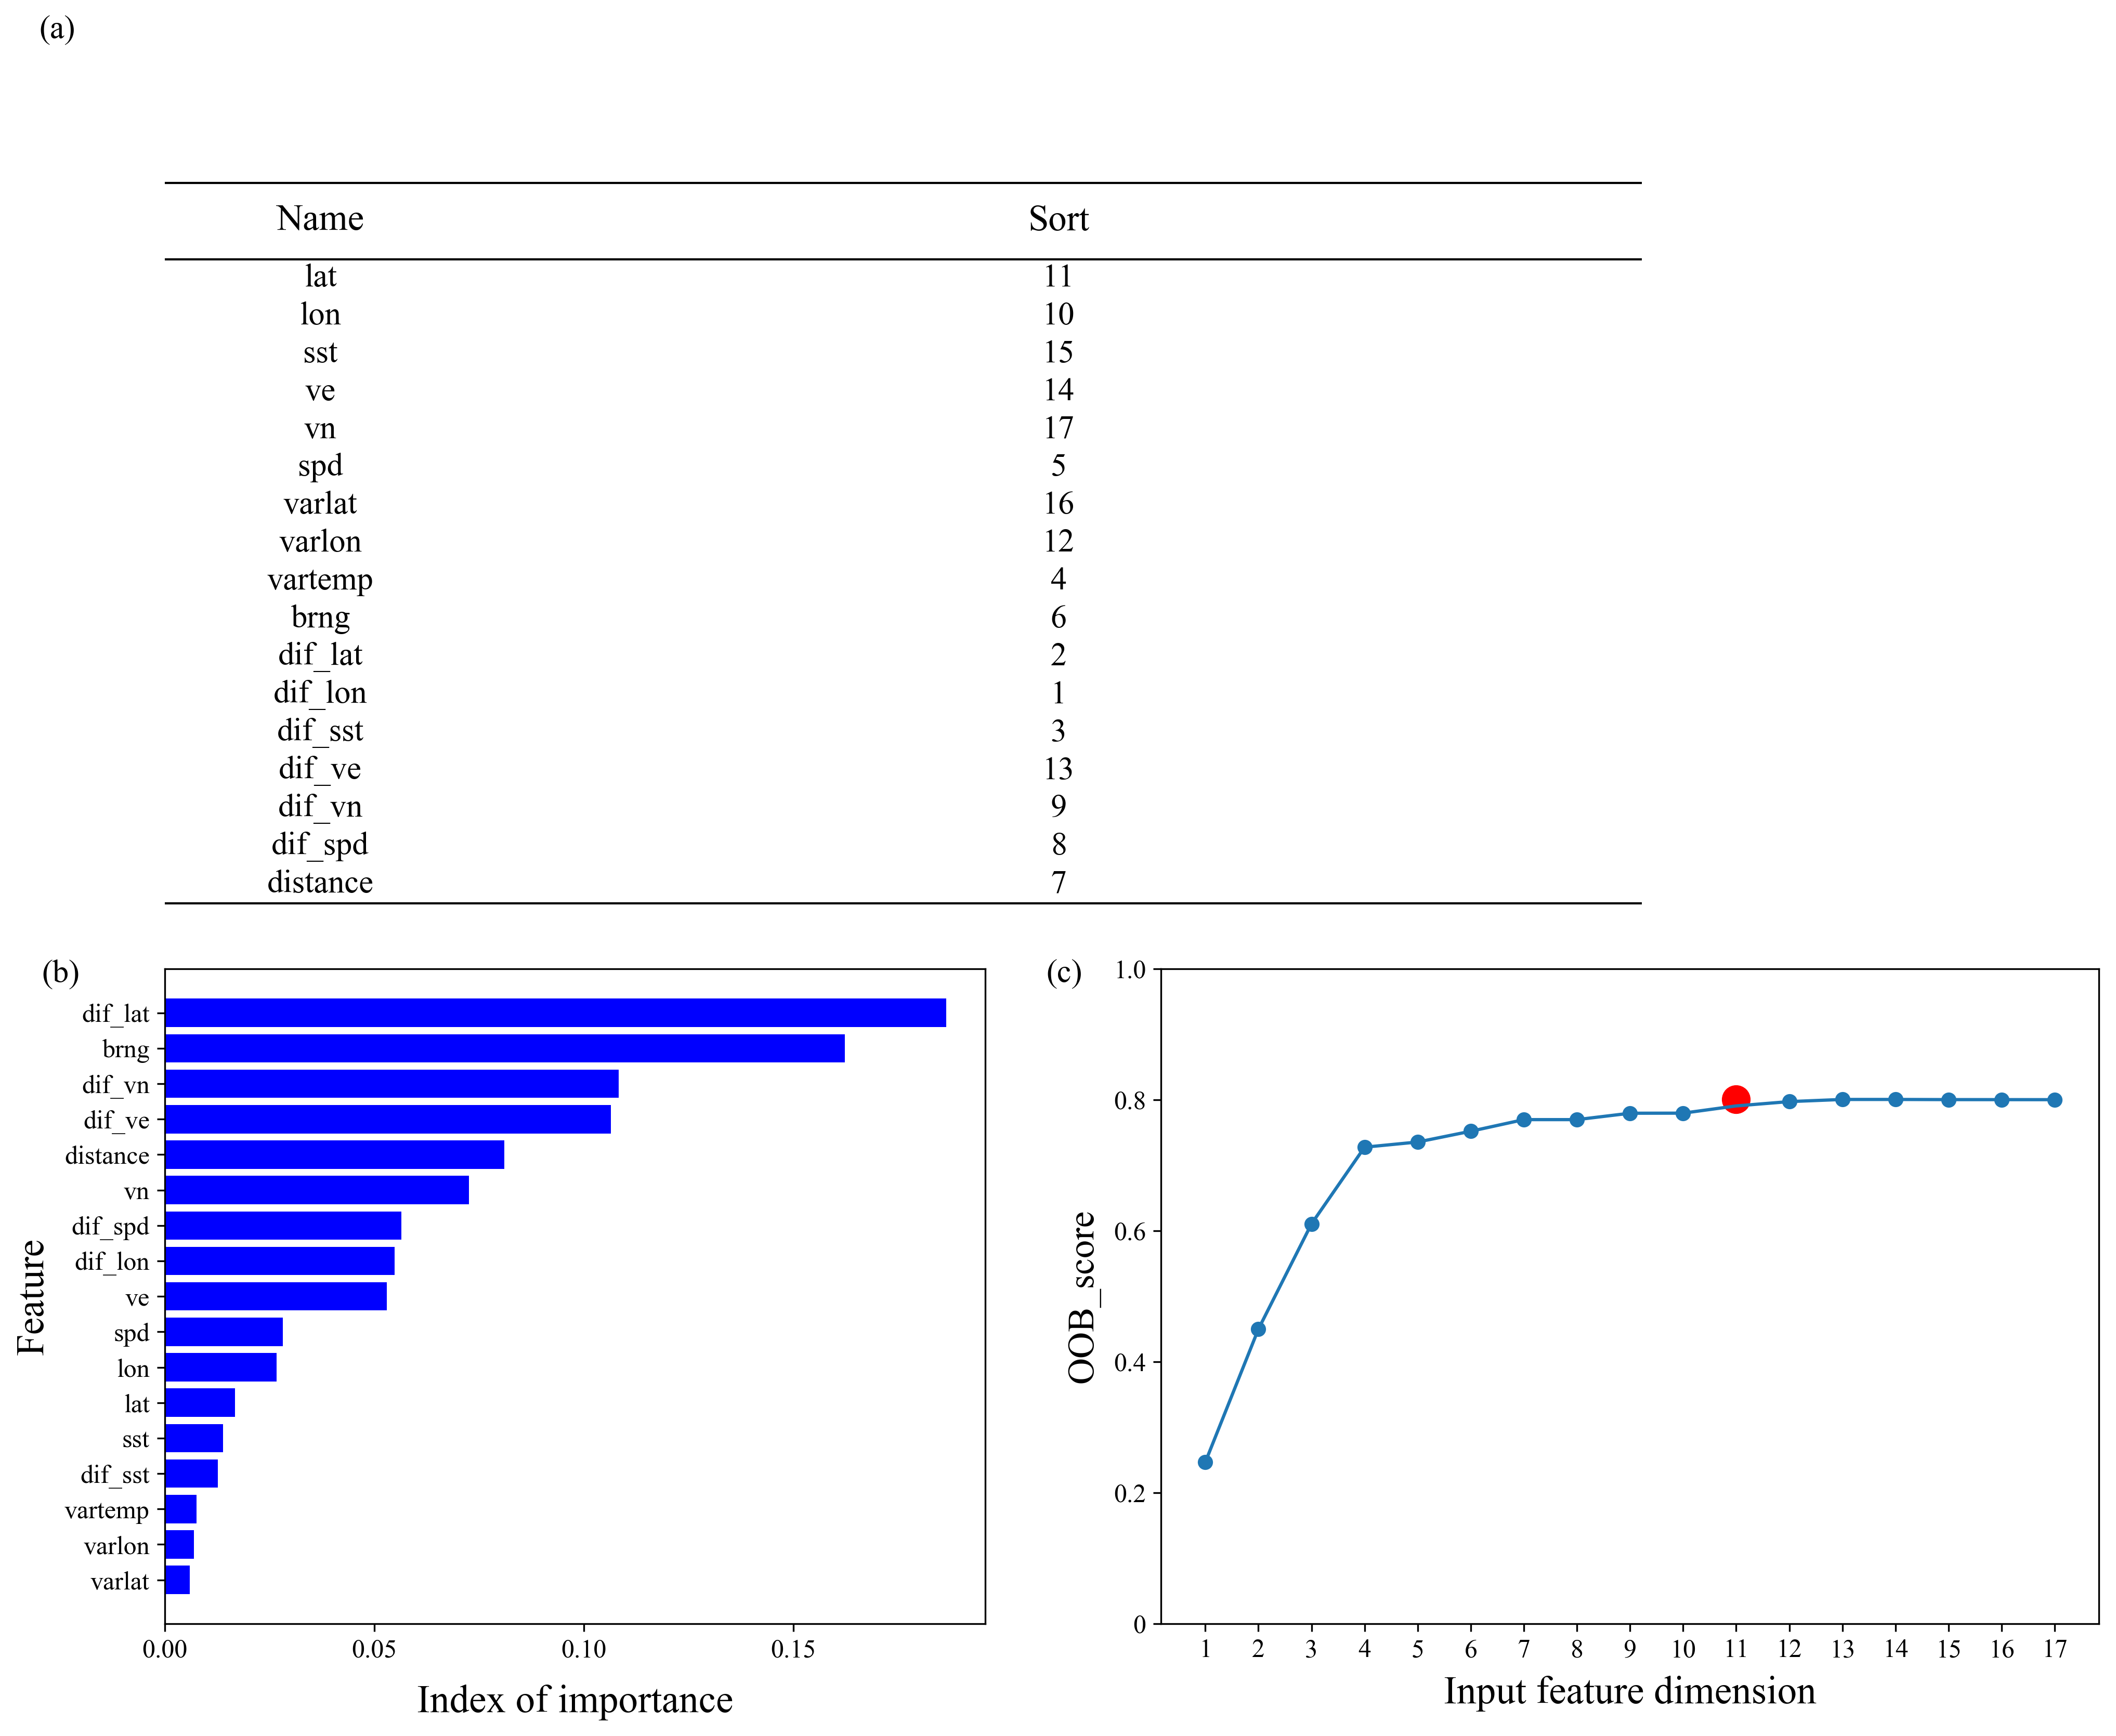

In [27]:
fig = plt.figure(figsize=(16, 12), dpi=300)
plt.rcParams.update({'font.family': 'Times New Roman','font.size': 12})
# matplotlib.rc("font",family='SimHei')
long_names=["1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "11",
            "12",
            "13",
            "14",
            "15",
            "16",
            "17"]
y_pos = np.arange(1,feature_size+1)
short_name=['lat','lon','sst','ve','vn','spd','varlat','varlon','vartemp','brng','dif_lat','dif_lon','dif_sst','dif_ve','dif_vn','dif_spd','distance']
short_name_1 = ['dif_lat','brng','dif_vn','dif_ve','distance','vn','dif_spd','dif_lon','ve','spd','lon','lat','sst','dif_sst','vartemp','varlon','varlat',
]
var_names=np.array(short_name_1[::-1])
gs=gridspec.GridSpec(2,2,width_ratios=[7,8])
ax2=fig.add_subplot(gs[2])
importance_feature=np.array(importance_feature_ds)
index_print=np.argsort(importance_feature)# -：从小到大    
ax2.set_yticks(np.arange(1,feature_size+1))
ax2.set_xticks(np.arange(0,0.45,0.05))
ax2.set_yticklabels(var_names)
ax2.set_xlabel('Index of importance',fontdict={'fontsize':18},labelpad=10)
ax2.set_ylabel('Feature',fontdict={'fontsize':18},labelpad=6)
ax2.barh(y_pos, importance_feature[index_print], color = "blue")
plt.text(-0.03,44.5,'(a)',fontsize=15)

ax1=fig.add_subplot(gs[0])
ax1.set_axis_off()
index_print_max=np.argsort(-importance_feature)
long_names=np.array(long_names)
var_names_maxsort=long_names[index_print_max]

feature=[list(t) for t in zip(short_name,var_names_maxsort)]
feature=np.array(feature)
rowLabel=[str(i) for i in range(1,feature_size+1)]
# colLabel=['Short_name','Long_name']
colLabel=['Name','Sort']
tab=ax1.table(cellText=feature,
        colLabels=colLabel,
#         rowLabels=rowLabel,      
         cellLoc='center',bbox=[0,-0.1,1.8,1.1],edges='open')
tab.auto_set_font_size(False)
tab.set_fontsize(15)
cell_dict = tab.get_celld()
for i in range(feature_size+1):
    cell_dict[(i,0)].set_width(0.4)
    cell_dict[(i,1)].set_width(1.5)
cell_dict[(0,0)].visible_edges='T','B'
cell_dict[(0,1)].visible_edges='T','B'
cell_dict[(feature_size,0)].visible_edges='B'
cell_dict[(feature_size,1)].visible_edges='B'
cell_dict[(0,0)].set(height=0.08,fontsize=17,linestyle='-')
cell_dict[(0,1)].set(height=0.08,fontsize=17,linestyle='-')
plt.text(-0.15,-0.22,'(b)',fontsize=15)
plt.rcParams.update({'font.family': 'Times New Roman','font.size': 12})
ax3=fig.add_subplot(gs[3])
oob_score=oob_score_24
x=np.arange(1,feature_size+1)
ax3.set_xticks(np.arange(1,feature_size+1))
ax3.set_xlabel('Input feature dimension',fontdict={'fontsize':18},labelpad=6)
ax3.set_ylabel('OOB_score',fontdict={'fontsize':17},labelpad=6)
ax3.plot(x, oob_score[0:])
ax3.scatter(x, oob_score[0:])

ax3.set_ylim(0,1)
ax3.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax3.set_yticklabels(['0','0.2','0.4','0.6','0.8','1.0'])
ax3.scatter(11, score_max_24,marker='o',color='r',s=150)
plt.text(-2,0.98,'(c)',fontsize=15)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
# plt.savefig('./feature_importance.png',bbox_inches='tight')

In [ ]:
long_names=["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17"]
y_pos = np.arange(1,feature_size+1)
short_name=['lat','lon','sst','ve','vn','spd','varlat','varlon','vartemp','brng','dif_lat','dif_lon','dif_sst','dif_ve','dif_vn','dif_spd','distance']
short_name_1 = ['dif_lat','brng','dif_vn','dif_ve','distance','vn','dif_spd','dif_lon','ve','spd','lon','lat','sst','dif_sst','vartemp','varlon','varlat',
]
var_names=np.array(short_name_1[::-1])
gs=gridspec.GridSpec(2,2,width_ratios=[7,8])

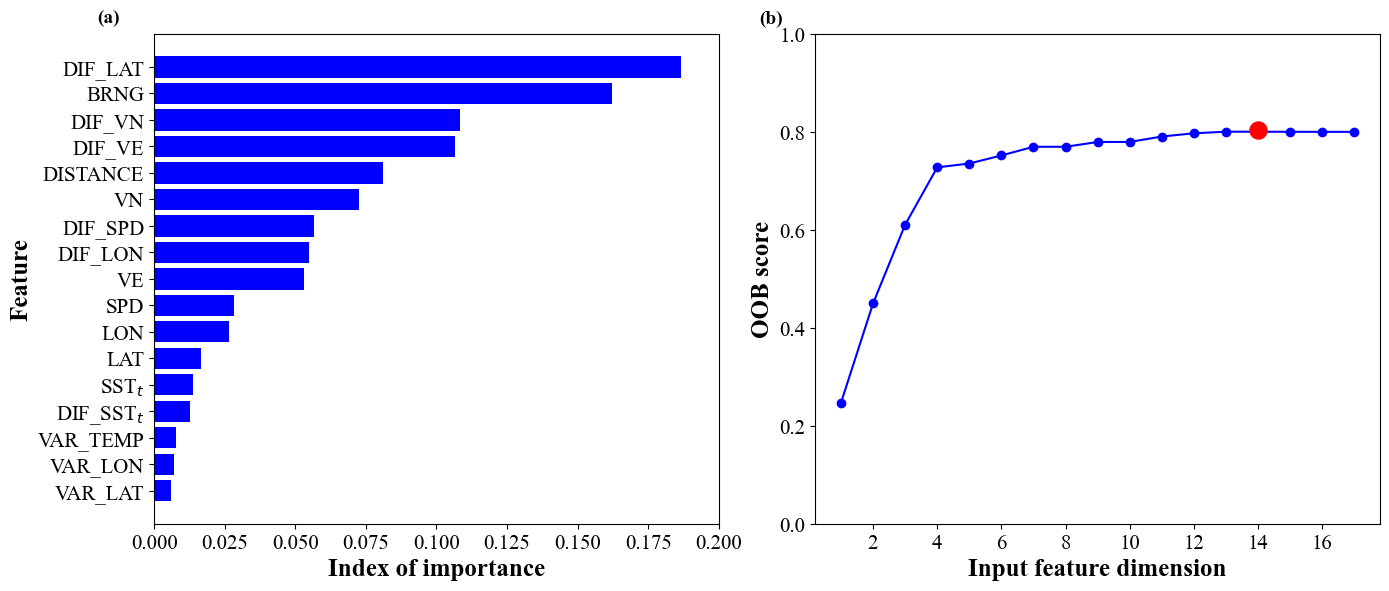

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Times New Roman'

# 模拟数据
features = ['DIF_LAT', 'BRNG', 'DIF_VN', 'DIF_VE', 'DISTANCE', 'VN', 'DIF_SPD', 'DIF_LON', 'VE', 'SPD', 'LON', 'LAT', 'SST$_t$', r'DIF_SST$_t$', 'VAR_TEMP', 'VAR_LON', 'VAR_LAT']
importance_feature_ds = [0.01674567, 0.02662099, 0.01384748, 0.053001,0.07261549, 0.0281159,0.00595079, 0.00694312, 0.00760109, 0.16226162, 0.18650538, 0.0548286,0.01267095, 0.10649922, 0.10832262, 0.05649642, 0.08097366]
importance_feature=np.array(importance_feature_ds)
index_print=np.argsort(importance_feature)# -：从小到大 

# 逆序排列
features = features[::-1]
importance = importance_feature[::-1]

input_feature_dimension = list(range(1, 18))
oob_score = [0.24690258946025764, 0.45003786183136335, 0.6107205890026034, 0.7278015049981535, 0.7356972429868645, 0.7521332735148362, 0.7698900718330223, 0.7698784730575449, 0.7796363792445167, 0.7797623531308924, 0.7908141971232402, 0.7974120474666039, 0.8006739517849989, 0.8006886080259493, 0.8004410681945601, 0.8003975005936069, 0.8003391083160362]

feature_size = 17
x=np.arange(1,feature_size+1)

score_max_24 = 0.795

# 创建图表
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 左侧柱状图
ax1.barh(features, importance_feature[index_print], color='blue')
ax1.set_xlabel('Index of importance',fontsize=18,fontweight='bold')
ax1.set_ylabel('Feature',fontsize=18,fontweight='bold')
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlim(0,0.2)
ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# 右侧折线图
ax2.plot(x, oob_score[0:],color='blue',zorder=1)
ax2.scatter(x, oob_score[0:],color='blue')
ax2.scatter(14, score_max_24+0.01,marker='o',color='r',s=150,zorder=2)
ax2.set_xlabel('Input feature dimension',fontsize=18,fontweight='bold')
# ax2.xaxis.set_label_coords(0.5, -0.05)
ax2.set_ylabel('OOB score',fontsize=18,fontweight='bold')
ax2.set_ylim(0,1)
ax2.tick_params(axis='both', labelsize=15)
ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')


plt.tight_layout()
plt.show()
